In [2]:
import sys
sys.executable


'c:\\Users\\lanam\\AppData\\Local\\Programs\\Python\\Python313\\python.exe'

In [3]:
import sys
!{sys.executable} -m pip install scikit-learn


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 8.7/8.7 MB 54.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ----------------- ---------------------- 16.8/38.5 MB 85.2 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/38.5 MB 78.6 MB/s eta 0:00:01
   ---------------------------------------- 38.5/38.5 MB 72.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# Imports & load cleaned data
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

CLEAN_PATH = Path("../data/clean")

summary = pd.read_csv(CLEAN_PATH / "summary_clean.csv")
patient = pd.read_csv(CLEAN_PATH / "patient_clean.csv")
services = pd.read_csv(CLEAN_PATH / "services_clean.csv")

summary.head()


C:\Users\lanam\AppData\Local\Temp\ipykernel_32300\595508775.py:18: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  summary = pd.read_csv(CLEAN_PATH / "summary_clean.csv")
C:\Users\lanam\AppData\Local\Temp\ipykernel_32300\595508775.py:19: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  patient = pd.read_csv(CLEAN_PATH / "patient_clean.csv")


,year,locationabbr,locationdesc,facilityname,city,clinic_status,topic,subtopic,question,breakout_category,breakout,data_value,data_value_num,cycle_count,clinicid,geolocation,year.1
0,2020,OH,Ohio,Institute for Reproductive Health,Cincinnati,Open,Summary,Footnote,Cycles evaluating new procedures,NaN,NaN,0,0,NaN,143,POINT (-84.4439587 39.148408),2020
1,2020,OK,Oklahoma,OU Physicians Reproductive Medicine,Oklahoma City,Open,Summary,"Characteristics of ART Cycles (a,b)",Percentage of cycles discontinued after retrie...,Age of Patient,<35,6.3,6.3,410,9,POINT (-97.5009249 35.4774816),2020
2,2020,NY,New York,Strong Fertility Center,Rochester,Open,Summary,"Reason for Using ART (a,b,g)",Gestational carrier,NaN,NaN,0,0,762,357,POINT (-77.6303291 43.0645425),2020
3,2020,CO,Colorado,Rocky Mountain Fertility Center,Englewood,Open,Summary,Footnote,Cycles evaluating new procedures,NaN,NaN,0,0,NaN,299,POINT (-104.841853 39.5367013),2020
4,2020,NC,North Carolina,UNC Fertility,Raleigh,Open,Summary,Clinic Services & Profile,Donor egg services,Yes/No,Yes,Yes,0,NaN,344,POINT (-78.7636599 35.9067499),2020


In [3]:
# Filter rows that describe live-birth per transfer, by age
live_birth = summary[
    summary["question"].str.contains("transfers resulting in live-birth", case=False, na=False)
    & summary["breakout_category"].str.contains("Age", case=False, na=False)
].copy()

live_birth = live_birth[[
    "year", "locationabbr", "facilityname", "breakout", "data_value_num", "cycle_count"
]]

live_birth.rename(columns={
    "locationabbr": "state",
    "breakout": "age_group",
    "data_value_num": "live_birth_rate"
}, inplace=True)

# Convert to numeric
live_birth["live_birth_rate"] = pd.to_numeric(live_birth["live_birth_rate"], errors="coerce")
live_birth["cycle_count"] = pd.to_numeric(live_birth["cycle_count"], errors="coerce")

# Drop rows with missing rate
live_birth = live_birth.dropna(subset=["live_birth_rate"])

live_birth.head()


,year,state,facilityname,age_group,live_birth_rate,cycle_count
121,2020,FL,"Advanced Reproductive Specialists, Jacksonvill...",35-37,45.5,117.0
144,2020,CT,Center for Advanced Reproductive Services,35-37,55.0,815.0
390,2020,OK,Bennett Fertility Institute,38-40,44.0,195.0
473,2020,CT,Reproductive Medicine Associates of Connecticut,38-40,49.5,587.0
542,2020,TX,"Fertility Specialists of Texas, PLLC",35-37,51.5,427.0


In [4]:
# Aggregate clinic volume per facility & year
clinic_volume = (
    live_birth
    .groupby(["facilityname", "year"])["cycle_count"]
    .sum()
    .reset_index()
    .rename(columns={"cycle_count": "clinic_volume"})
)

# Merge back into live_birth table
df = live_birth.merge(clinic_volume, on=["facilityname", "year"], how="left")

# Basic cleaning
df = df.dropna(subset=["clinic_volume", "live_birth_rate"])
df["clinic_volume"] = df["clinic_volume"].astype(float)
df["year"] = df["year"].astype(int)

df.head()


,year,state,facilityname,age_group,live_birth_rate,cycle_count,clinic_volume
0,2020,FL,"Advanced Reproductive Specialists, Jacksonvill...",35-37,45.5,117.0,468.0
1,2020,CT,Center for Advanced Reproductive Services,35-37,55.0,815.0,3260.0
2,2020,OK,Bennett Fertility Institute,38-40,44.0,195.0,780.0
3,2020,CT,Reproductive Medicine Associates of Connecticut,38-40,49.5,587.0,2348.0
4,2020,TX,"Fertility Specialists of Texas, PLLC",35-37,51.5,427.0,1708.0


In [ ]:
# Define target - high vs low success
THRESHOLD = 40.0

df["target_high_success"] = (df["live_birth_rate"] >= THRESHOLD).astype(int)

df[["live_birth_rate", "target_high_success"]].head()
df["target_high_success"].value_counts()


target_high_success
0    3470
1    1978
Name: count, dtype: int64

In [ ]:
# Clean df 

df_model = df.copy()

# Remove territories and low-sample states
# Count how many records per state
state_counts = df_model["state"].value_counts()

# Keep only states with at least 30 observations
valid_states = state_counts[state_counts >= 30].index

df_model = df_model[df_model["state"].isin(valid_states)]

# exclude Puerto Rico or DC manually
df_model = df_model[~df_model["state"].isin(["PR", "DC"])]

# Build X and Y

feature_cols = ["year", "clinic_volume", "state", "age_group"]

X = df_model[feature_cols].copy()
y = df_model["target_high_success"]


X = pd.get_dummies(X, columns=["state", "age_group"], drop_first=True)

#Show result
X.head(), y.head()



(   year  clinic_volume  state_AZ  state_CA  state_CO  state_CT  state_FL  \
 0  2020          468.0     False     False     False     False      True   
 1  2020         3260.0     False     False     False      True     False   
 2  2020          780.0     False     False     False     False     False   
 3  2020         2348.0     False     False     False      True     False   
 4  2020         1708.0     False     False     False     False     False   
 
    state_GA  state_HI  state_IL  ...  state_SC  state_TN  state_TX  state_UT  \
 0     False     False     False  ...     False     False     False     False   
 1     False     False     False  ...     False     False     False     False   
 2     False     False     False  ...     False     False     False     False   
 3     False     False     False  ...     False     False     False     False   
 4     False     False     False  ...     False     False      True     False   
 
    state_VA  state_WA  state_WI  age_group_38-4

In [28]:
# Train/Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((3586, 38), (1538, 38))

In [29]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7613784135240572

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       975
           1       0.70      0.61      0.65       563

    accuracy                           0.76      1538
   macro avg       0.75      0.73      0.74      1538
weighted avg       0.76      0.76      0.76      1538



In [30]:
# Decision Tree model
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_tree))


Decision Tree Accuracy: 0.8081924577373212

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       975
           1       0.71      0.80      0.75       563

    accuracy                           0.81      1538
   macro avg       0.79      0.81      0.80      1538
weighted avg       0.82      0.81      0.81      1538



In [44]:
# Feature importance (Decision Tree)
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": tree.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(15)


,feature,importance
1,clinic_volume,0.459991
37,age_group_>40,0.359823
35,age_group_38-40,0.092361
36,age_group_<35,0.075799
26,state_OR,0.007101
8,state_HI,0.004035
3,state_CA,0.000890
4,state_CO,0.000000
2,state_AZ,0.000000
0,year,0.000000


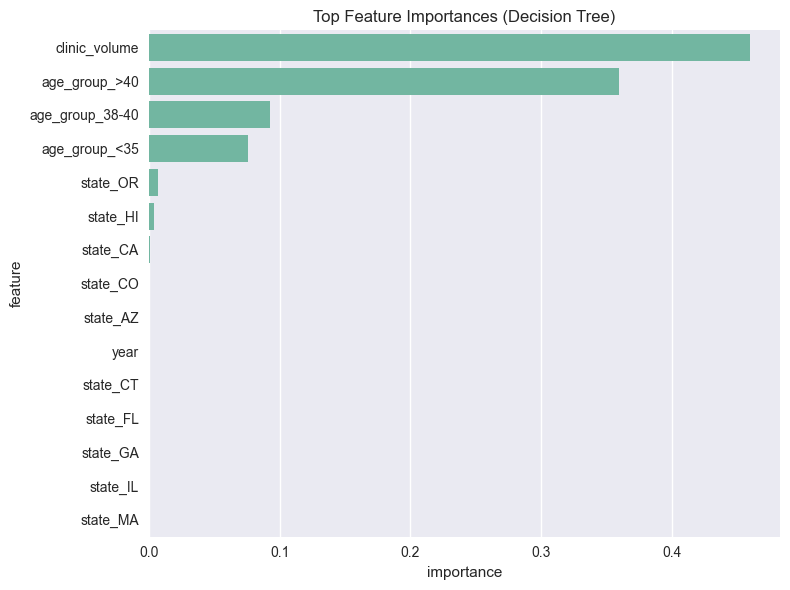

In [45]:
# Visualization
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(15), x="importance", y="feature")
plt.title("Top Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()


In [46]:
# Interpret Logistic Regression coefficients (positive - increase probability of high success)
coeff = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)

coeff.head(20)


,feature,coef
26,state_OR,1.173895
20,state_NC,0.996644
36,age_group_<35,0.888456
17,state_MN,0.687575
22,state_NV,0.616704
2,state_AZ,0.594968
5,state_CT,0.557318
28,state_SC,0.493497
13,state_LA,0.470015
33,state_WA,0.468366


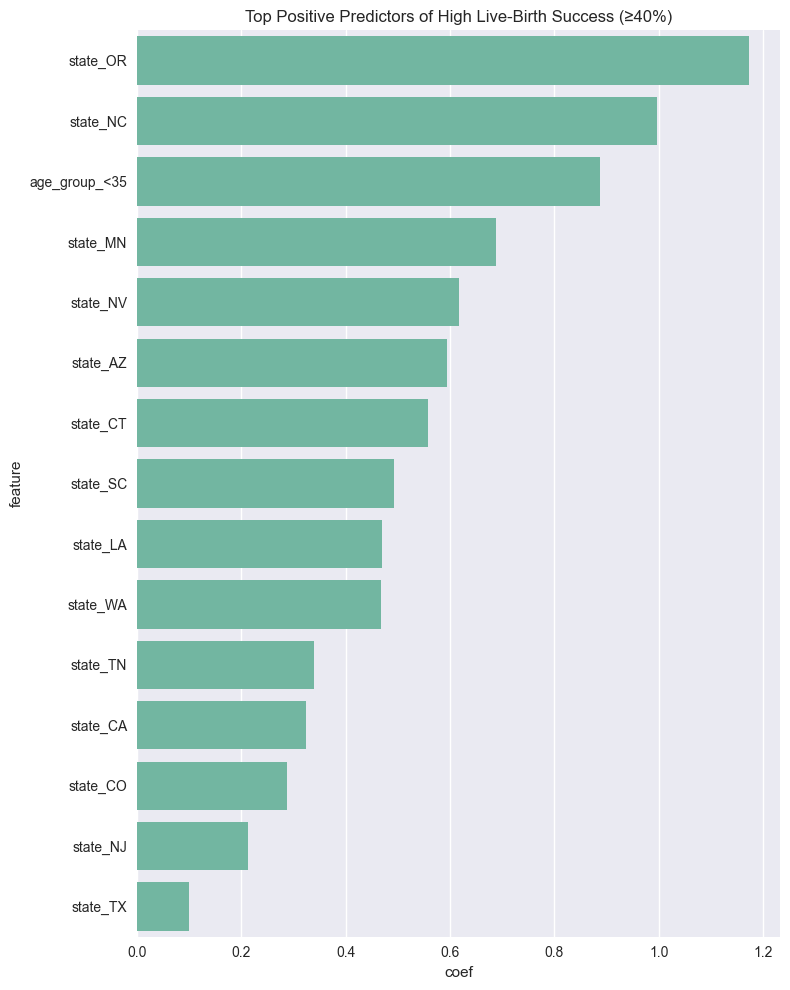

In [ ]:
# Coefficients visualization - positive predictors
coeff = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=coeff.head(15), x="coef", y="feature")
plt.title("Top Positive Predictors of High Live-Birth Success (≥40%)")
plt.tight_layout()
plt.show()


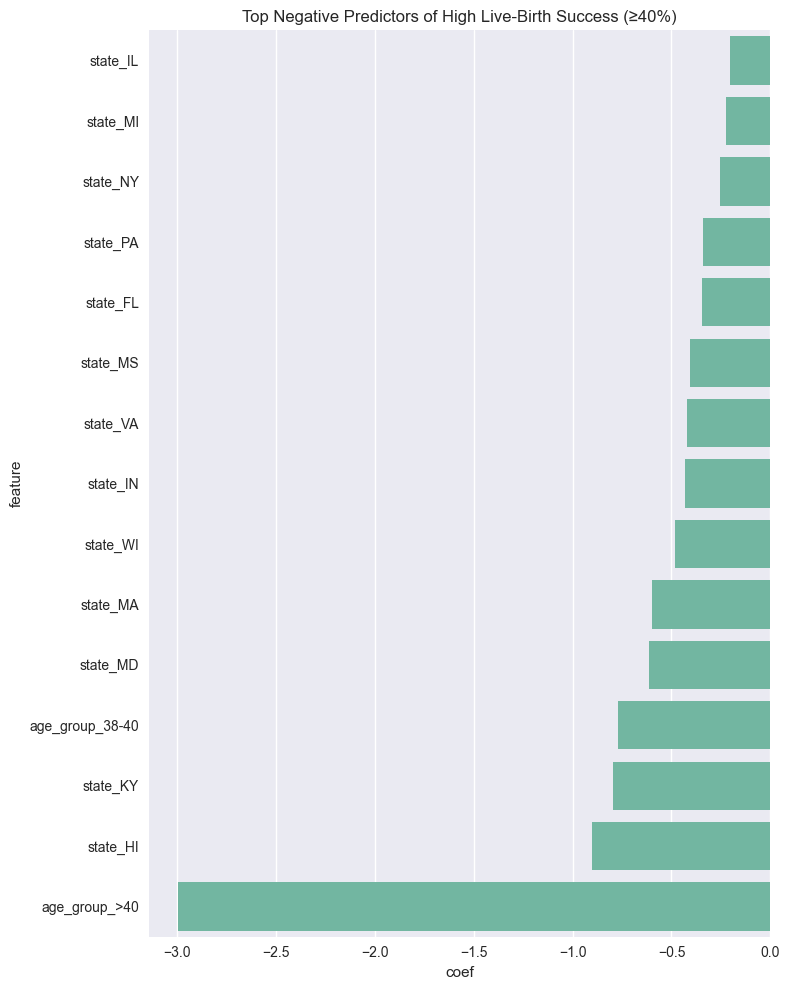

In [ ]:
# Coefficients visualization - negative predictors
plt.figure(figsize=(8,10))
sns.barplot(data=coeff.tail(15), x="coef", y="feature")
plt.title("Top Negative Predictors of High Live-Birth Success (≥40%)")
plt.tight_layout()
plt.show()


In [36]:
# Split the coefficients into age-group and state-only charts
coeff = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0]
}).sort_values("coef", ascending=False)
coeff.head()


,feature,coef
26,state_OR,1.173895
20,state_NC,0.996644
36,age_group_<35,0.888456
17,state_MN,0.687575
22,state_NV,0.616704


In [39]:
# Extract age group coefficient
coeff_age = coeff[coeff["feature"].str.contains("age_group")]
coeff_age = coeff_age.reindex(coeff_age["coef"].abs().sort_values(ascending=False).index)
coeff_age


,feature,coef
37,age_group_>40,-2.992854
36,age_group_<35,0.888456
35,age_group_38-40,-0.770910


C:\Users\lanam\AppData\Local\Temp\ipykernel_32300\2881857600.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeff_age, x="coef", y="feature", palette="Set2")


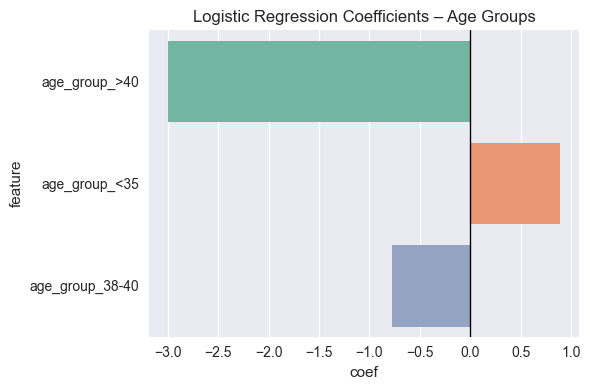

In [40]:
# Plot age group coefficient
plt.figure(figsize=(6,4))
sns.barplot(data=coeff_age, x="coef", y="feature", palette="Set2")
plt.title("Logistic Regression Coefficients – Age Groups")
plt.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


In [ ]:
# Extract state coefficient
coeff_states = coeff[coeff["feature"].str.contains("state_")].copy()

# Sort by absolute coefficient value
coeff_states = coeff_states.sort_values(by="coef", key=lambda x: x.abs(), ascending=False)

coeff_states.head(10)


,feature,coef
26,state_OR,1.173895
20,state_NC,0.996644
8,state_HI,-0.899901
12,state_KY,-0.793916
17,state_MN,0.687575
22,state_NV,0.616704
15,state_MD,-0.614363
14,state_MA,-0.599113
2,state_AZ,0.594968
5,state_CT,0.557318


C:\Users\lanam\AppData\Local\Temp\ipykernel_32300\3506616849.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x="coef", y="feature", palette="Set2")


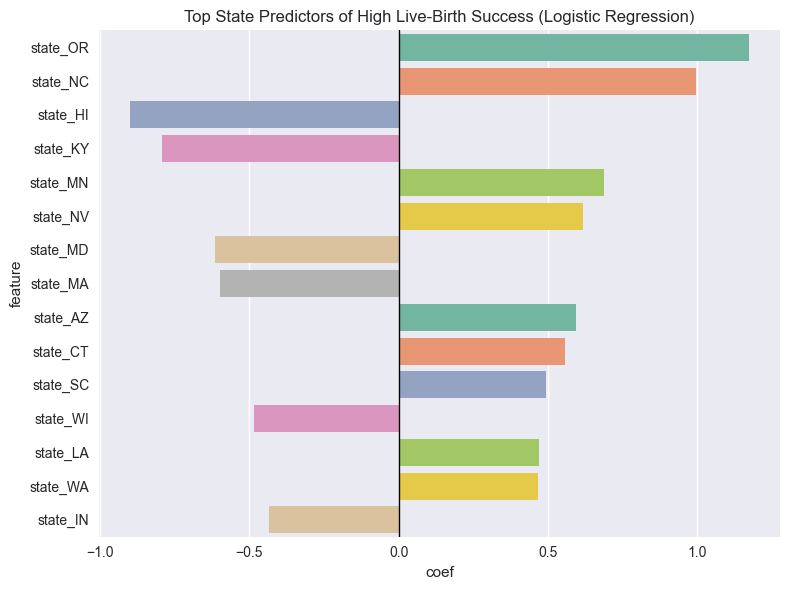

In [42]:
# Plot the top 15 state coefficient
top_states = coeff_states.head(15)

plt.figure(figsize=(8,6))
sns.barplot(data=top_states, x="coef", y="feature", palette="Set2")
plt.title("Top State Predictors of High Live-Birth Success (Logistic Regression)")
plt.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()

